## Import all the necessary libraries

In [1]:
import csv
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics
import matplotlib.pyplot as plt  
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm 
from sklearn.preprocessing import FunctionTransformer
import itertools    
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

## Load the keys to query the data. This step is omitted for Fall 2022 Hack 

In [2]:
import os
BIGQUERY_PROJECT = 'cloud-test-ironhacks'
BIGQUERY_KEYPATH = 'cloud-test-ironhacks-c1010c49a602.json'

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = BIGQUERY_KEYPATH
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

## Query the data and see how they look like

In [3]:
query = """
SELECT * FROM `cloud-test-ironhacks.dwd_data.suppression_remove`

"""

query_job = bigquery_client.query(query)
data = query_job.to_dataframe()
data = data[data['uu_id'].notnull() & data['total_claims'].notnull()]
data 

,uu_id,timeperiod,week_number,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,...,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white
5,9bee42b55f891413ae7fac2d9d89280a,20220212,7,18003,100,"Census Tract 1, Allen County, Indiana",10.0,0.0,0.0,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN
7,9bee42b55f891413ae7fac2d9d89280a,20220226,9,18003,100,"Census Tract 1, Allen County, Indiana",10.0,0.0,0.0,NaN,...,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN
11,9bee42b55f891413ae7fac2d9d89280a,20220326,13,18003,100,"Census Tract 1, Allen County, Indiana",13.0,0.0,NaN,NaN,...,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0
14,9bee42b55f891413ae7fac2d9d89280a,20220416,16,18003,100,"Census Tract 1, Allen County, Indiana",15.0,0.0,0.0,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,12.0
15,9bee42b55f891413ae7fac2d9d89280a,20220423,17,18003,100,"Census Tract 1, Allen County, Indiana",23.0,0.0,0.0,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72119,22804b1ddf209d3876385dd3ffa8392d,20220226,9,18065,976800,"Census Tract 9768, Henry County, Indiana",13.0,NaN,0.0,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0
72123,22804b1ddf209d3876385dd3ffa8392d,20220326,13,18065,976800,"Census Tract 9768, Henry County, Indiana",11.0,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0
72147,22804b1ddf209d3876385dd3ffa8392d,20220903,36,18065,976800,"Census Tract 9768, Henry County, Indiana",29.0,0.0,0.0,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0
72148,22804b1ddf209d3876385dd3ffa8392d,20220903,36,18065,976800,"Census Tract 9768, Henry County, Indiana",29.0,0.0,0.0,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0


In [4]:
data = data.sort_values('week_number')
data

,uu_id,timeperiod,week_number,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,...,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white
39313,6239669cbfe444abd0a46536a670d150,20220101,1,18039,400,"Census Tract 4, Elkhart County, Indiana",16.0,0.0,NaN,NaN,...,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,13.0
34963,57bc30b16bd1a7875fc59a57c0363cd3,20220101,1,18097,356400,"Census Tract 3564, Marion County, Indiana",11.0,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN
34819,8cb479dc5fba577ea3013a189045ff7b,20220101,1,18097,355700,"Census Tract 3557, Marion County, Indiana",16.0,0.0,NaN,12.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN
7974,601ff2c0fd709298f6644ad0e766b2d6,20220101,1,18141,1100,"Census Tract 11, St. Joseph County, Indiana",13.0,0.0,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN
34770,4fe5a3188b15f262431ed884f3619d8b,20220101,1,18097,355600,"Census Tract 3556, Marion County, Indiana",19.0,NaN,NaN,10.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3008,bbcb018f0e5e49e13636f6e78ce9f60f,20221008,41,18163,10203,"Census Tract 102.03, Vanderburgh County, Indiana",22.0,0.0,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,NaN,18.0
14637,e24fca963ee2f4a4593900385e64051c,20221008,41,18095,12000,"Census Tract 120, Madison County, Indiana",11.0,0.0,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN
54325,6e34d7b45dd1daecd65ac963cd344e2d,20221008,41,18145,710500,"Census Tract 7105, Shelby County, Indiana",11.0,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN
44100,9d137c34d4598e4f67aac16df77037e0,20221008,41,18089,42501,"Census Tract 425.01, Lake County, Indiana",30.0,0.0,NaN,17.0,...,12.0,18.0,0.0,0.0,0.0,18.0,NaN,NaN,NaN,NaN


## Cumulate the data according to the week_number. 

In [5]:
# predict week 39 with week 1 - week 38

df_week39_lag1 = data.groupby(['week_number']).total_claims.sum().groupby(level=0).cumsum().reset_index()
df_week39_lag1 = df_week39_lag1[df_week39_lag1['week_number'] < 39]

# predict week 40 with week 1 - week 39

df_week40_lag1 = data.groupby(['week_number']).total_claims.sum().groupby(level=0).cumsum().reset_index()
df_week40_lag1 = df_week40_lag1[df_week40_lag1['week_number'] < 40]

# predict week 41 with week 1 - week 40

df_week41_lag1 = data.groupby(['week_number']).total_claims.sum().groupby(level=0).cumsum().reset_index()
df_week41_lag1 = df_week41_lag1[df_week41_lag1['week_number'] < 41]

# predict week 39 with week 1 - week 36

df_week39_lag2 = data.groupby(['week_number']).total_claims.sum().groupby(level=0).cumsum().reset_index()
df_week39_lag2 = df_week39_lag2[df_week39_lag2['week_number'] < 37]

# predict week 40 with week 1 - week 37

df_week40_lag2 = data.groupby(['week_number']).total_claims.sum().groupby(level=0).cumsum().reset_index()
df_week40_lag2 = df_week40_lag2[df_week40_lag2['week_number'] < 38]

# predict week 41 with week 1 - week 40

df_week41_lag2 = data.groupby(['week_number']).total_claims.sum().groupby(level=0).cumsum().reset_index()
df_week41_lag2 = df_week41_lag2[df_week41_lag2['week_number'] < 39]

## Plot the overall data to see how the trend looks like when lagging 1 week 

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='week_number', ylabel='total_claims'>

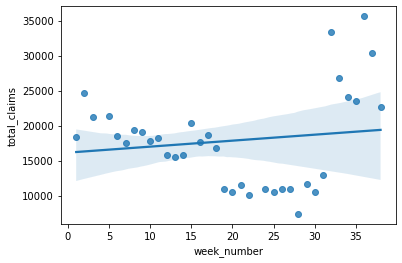

In [6]:
sns.regplot(df_week39_lag1['week_number'], df_week39_lag1['total_claims'])

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='week_number', ylabel='total_claims'>

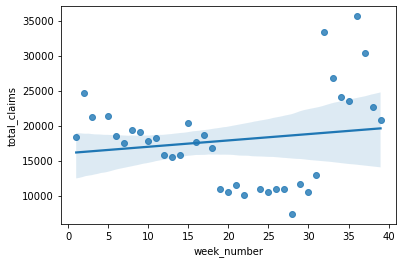

In [7]:
sns.regplot(df_week40_lag1['week_number'], df_week40_lag1['total_claims'])

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='week_number', ylabel='total_claims'>

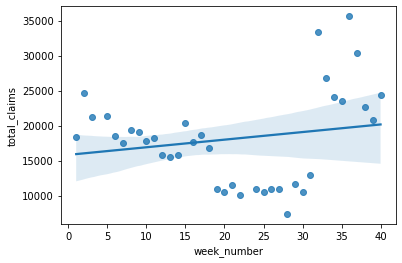

In [8]:
sns.regplot(df_week41_lag1['week_number'], df_week41_lag1['total_claims'])

## Plot the overall data to see how the trend looks like when lagging 2 weeks

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='week_number', ylabel='total_claims'>

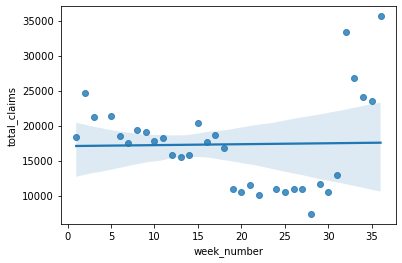

In [9]:
sns.regplot(df_week39_lag2['week_number'], df_week39_lag2['total_claims'])

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='week_number', ylabel='total_claims'>

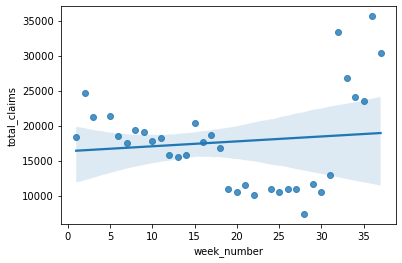

In [10]:
sns.regplot(df_week40_lag2['week_number'], df_week40_lag2['total_claims'])

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='week_number', ylabel='total_claims'>

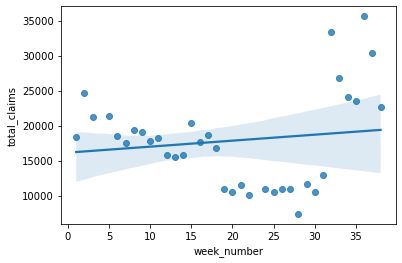

In [11]:
sns.regplot(df_week41_lag2['week_number'], df_week41_lag2['total_claims'])

## Start performing predictions on the overall data without the granularity from uu_id

> We do this primarily to decide if we should go with Linear Regression or Lag Regression. Note there are many ways to forecast which model might work better. 

In [12]:
X = data['week_number'].values.reshape(-1,1)
y = data['total_claims'].values.reshape(-1,1)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.04, random_state = 0)

In [14]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

LinearRegression()

In [15]:
#To retrieve the intercept:
print(regressor.intercept_)

#For retrieving the slope:
print(regressor.coef_)

[21.37430335]
[[-0.04457384]]


In [16]:
y_pred = regressor.predict(X_test)

In [17]:
outcome = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
outcome

,Actual,Predicted
0,30.0,19.947941
1,14.0,19.858793
2,14.0,20.928565
3,15.0,19.814219
4,28.0,21.062287
...,...,...
1365,18.0,21.285156
1366,49.0,19.769645
1367,11.0,21.062287
1368,10.0,20.393679


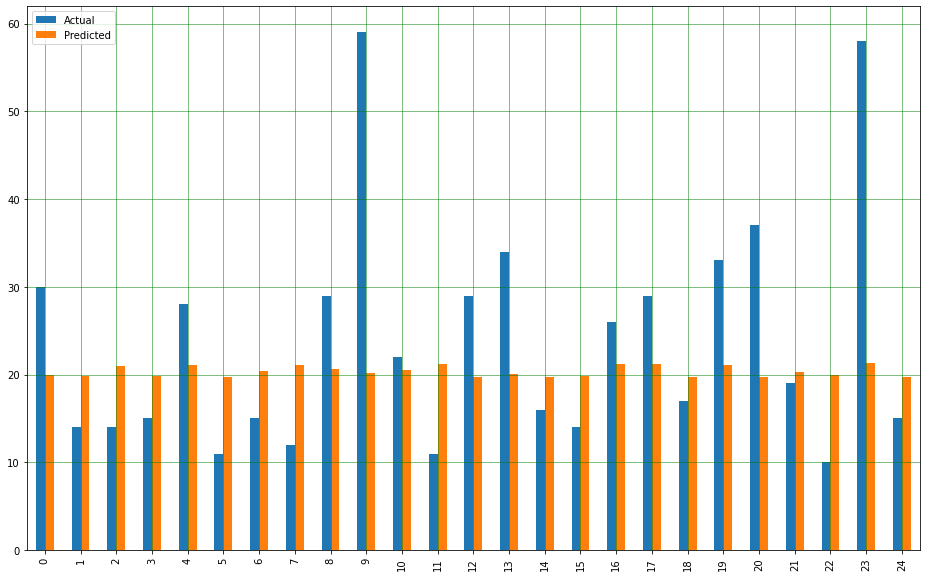

In [18]:
outcome = outcome.head(25)
outcome.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [19]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 9.321145477655888
Mean Squared Error: 221.2404521232856
Root Mean Squared Error: 14.874153828816132


## Start modeling with Lag Regression 

In [20]:
data['lag'] = data['total_claims'].shift(1).dropna()
data

,uu_id,timeperiod,week_number,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,...,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white,lag
39313,6239669cbfe444abd0a46536a670d150,20220101,1,18039,400,"Census Tract 4, Elkhart County, Indiana",16.0,0.0,NaN,NaN,...,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,13.0,NaN
34963,57bc30b16bd1a7875fc59a57c0363cd3,20220101,1,18097,356400,"Census Tract 3564, Marion County, Indiana",11.0,NaN,NaN,NaN,...,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,16.0
34819,8cb479dc5fba577ea3013a189045ff7b,20220101,1,18097,355700,"Census Tract 3557, Marion County, Indiana",16.0,0.0,NaN,12.0,...,NaN,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,11.0
7974,601ff2c0fd709298f6644ad0e766b2d6,20220101,1,18141,1100,"Census Tract 11, St. Joseph County, Indiana",13.0,0.0,NaN,NaN,...,NaN,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,16.0
34770,4fe5a3188b15f262431ed884f3619d8b,20220101,1,18097,355600,"Census Tract 3556, Marion County, Indiana",19.0,NaN,NaN,10.0,...,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,12.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3008,bbcb018f0e5e49e13636f6e78ce9f60f,20221008,41,18163,10203,"Census Tract 102.03, Vanderburgh County, Indiana",22.0,0.0,NaN,NaN,...,NaN,0.0,0.0,0.0,NaN,NaN,0.0,NaN,18.0,12.0
14637,e24fca963ee2f4a4593900385e64051c,20221008,41,18095,12000,"Census Tract 120, Madison County, Indiana",11.0,0.0,NaN,NaN,...,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,22.0
54325,6e34d7b45dd1daecd65ac963cd344e2d,20221008,41,18145,710500,"Census Tract 7105, Shelby County, Indiana",11.0,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,11.0
44100,9d137c34d4598e4f67aac16df77037e0,20221008,41,18089,42501,"Census Tract 425.01, Lake County, Indiana",30.0,0.0,NaN,17.0,...,18.0,0.0,0.0,0.0,18.0,NaN,NaN,NaN,NaN,11.0


In [21]:
X = data['lag'].dropna()
y = data['total_claims']
y, X = y.align(X, join='inner')  # drop corresponding values in target
X

34963    16.0
34819    11.0
7974     16.0
34770    13.0
2375     19.0
         ... 
3008     12.0
14637    22.0
54325    11.0
44100    11.0
24772    30.0
Name: lag, Length: 34227, dtype: float64

In [22]:
X = X.values.reshape(-1,1)
y = y.values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.04, random_state = 0)

regressor = LinearRegression().fit(X,y)

In [23]:
#To retrieve the intercept:
print(regressor.intercept_)

#For retrieving the slope:
print(regressor.coef_)

[18.28352323]
[[0.10418617]]


In [24]:
y_pred = regressor.predict(X_test)

In [25]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df

,Actual,Predicted
0,30.0,21.409108
1,14.0,19.742130
2,25.0,19.742130
3,21.0,19.846316
4,16.0,21.200736
...,...,...
1365,12.0,20.158874
1366,26.0,23.388645
1367,12.0,19.429571
1368,15.0,19.325385


In [26]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 8.780414777354125
Mean Squared Error: 173.62698389110147
Root Mean Squared Error: 13.176759233252366


## Now we decided we could use Linear Regression

## Sort the dataframe 

> Sort the dataframe according to week_number so that we can use test_train_split directly on the top portion of the dataframe as the training set by setting stratify = False and shuffle = False. There are many ways to doing this. 

In [27]:
data = data.sort_values('week_number')
data

,uu_id,timeperiod,week_number,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,...,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white,lag
39313,6239669cbfe444abd0a46536a670d150,20220101,1,18039,400,"Census Tract 4, Elkhart County, Indiana",16.0,0.0,NaN,NaN,...,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,13.0,NaN
69320,50b12b0d66623b613764bd10056a0807,20220101,1,18031,969300,"Census Tract 9693, Decatur County, Indiana",13.0,0.0,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,15.0
15434,51a955afdcc0c4de1b57a881226925c0,20220101,1,18095,1300,"Census Tract 13, Madison County, Indiana",24.0,0.0,NaN,11.0,...,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,13.0
23501,9200a2b83d869882f514fa76e6bcd05c,20220101,1,18035,2402,"Census Tract 24.02, Delaware County, Indiana",22.0,0.0,NaN,13.0,...,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,16.0,24.0
17375,b98ffdcf812945f0f095c05722332358,20220101,1,18003,1700,"Census Tract 17, Allen County, Indiana",14.0,0.0,NaN,NaN,...,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19243,6e869e8356fa1fd6ba750b7c894ffc1c,20221008,41,18089,20100,"Census Tract 201, Lake County, Indiana",10.0,0.0,0.0,NaN,...,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,12.0
58174,8267c703abd7db102110ec19c18ae372,20221008,41,18093,951200,"Census Tract 9512, Lawrence County, Indiana",20.0,0.0,NaN,12.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,10.0
42840,7ee27423441d3bced123afcec6335da8,20221008,41,18089,41302,"Census Tract 413.02, Lake County, Indiana",19.0,0.0,0.0,NaN,...,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,15.0,20.0
5626,f70960d492c2fd067680a14baa0f66e9,20221008,41,18167,10600,"Census Tract 106, Vigo County, Indiana",16.0,0.0,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,11.0


## Function to print the dataframe according to the desired output format. 

In [28]:
def printexcel(result, filename):
    frame = pd.DataFrame(list(result.items()), columns=['uu_id','total_claims'])
    frame['total_claims'] =  frame['total_claims'].apply(lambda x: str(x).replace('[','').replace(']',''))
    frame['total_claims'] = frame['total_claims'].astype(float)
    frame.to_csv(filename, index=False)

## Function to predict week 39 based on week 1 and week 38

In [29]:
week39  = data[data['week_number'] == 39]

In [30]:
data_week_38 = data[data['week_number'] < 39]

In [31]:
common = set(week39['uu_id']).intersection(data_week_38['uu_id'])

out = pd.concat([week39[week39['uu_id'].isin(common)], data_week_38[data_week_38['uu_id'].isin(common)]])
out = out.sort_values('week_number')
week_1_38 = out[out['week_number'] < 39]
week_39 = out[out['week_number'] == 39]

## Get only week 39 data 

In [32]:
def regressionsquare(data, yvar, xvars):
    X_train, X_test, y_train, y_test = train_test_split(data[xvars], data[yvar], train_size=0.9999, random_state=42, shuffle=False, stratify=None)
    result = sm.OLS(y_train, X_train).fit()
    predictions = result.predict(39)
    return predictions
result = week_1_38.groupby('uu_id').apply(regressionsquare, 'total_claims', 'week_number')
print(result)

uu_id
005be9532fd717dc36d4be318fd9ad25     [54.01802943581359]
0068776d88cb6d1ab5c7059fbd3dd3cb     [77.86446568201565]
00d85dff1c1f21f01f4f5f0bd683d32b    [28.336013261500213]
00eefd4f45685ac82f7df022c30b3810     [32.84210526315789]
00f962ce727b8dbbf20925abd5a253dd     [53.51033499643623]
                                            ...         
fd38d1859753f17df3c5f4df40197795    [23.082101870775027]
fd536ceeba7fcbabdd0444b1eba6cab4    [28.882397003745318]
fd613eba867c6ad7350a937f743b88f2     [29.11840600265362]
fe355ff27aa8b2242a558d5e3ec99c18    [20.679226896215695]
fec479d0202d6e1e3f051a9ee902ff5d    [41.506170986982795]
Length: 574, dtype: object


In [33]:
result_dict1 = week_1_38.groupby('uu_id').apply(regressionsquare, 'total_claims', 'week_number').to_dict()
printexcel(result_dict1, 'model-39-lag1.csv')

## Read the output file to compare actual and predicted value in week 39

In [34]:
df = pd.read_csv('model-39-lag1.csv')
df

,uu_id,total_claims
0,005be9532fd717dc36d4be318fd9ad25,54.018029
1,0068776d88cb6d1ab5c7059fbd3dd3cb,77.864466
2,00d85dff1c1f21f01f4f5f0bd683d32b,28.336013
3,00eefd4f45685ac82f7df022c30b3810,32.842105
4,00f962ce727b8dbbf20925abd5a253dd,53.510335
...,...,...
569,fd38d1859753f17df3c5f4df40197795,23.082102
570,fd536ceeba7fcbabdd0444b1eba6cab4,28.882397
571,fd613eba867c6ad7350a937f743b88f2,29.118406
572,fe355ff27aa8b2242a558d5e3ec99c18,20.679227


## Predicted value for week 39 ( lag 1 )

In [35]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [36]:
matching_39= week_39.loc[week_39['uu_id'].isin(df['uu_id'])]
matching_39 = matching_39.drop_duplicates('uu_id', keep='last')


In [37]:
mean_absolute_percentage_error(matching_39['total_claims'], df['total_claims'])

107.71579916477023

In [38]:
mean_squared_error(matching_39['total_claims'], df['total_claims'])

364.6717176909812

## Function to predict week 40 based on week 1 to week 39

In [39]:
week40  = data[data['week_number'] == 40]

In [40]:
data_week_39 = data[data['week_number'] < 40]

In [41]:
common = set(week40['uu_id']).intersection(data_week_39['uu_id'])

out = pd.concat([week40[week40['uu_id'].isin(common)], data_week_39[data_week_39['uu_id'].isin(common)]])
out = out.sort_values('week_number')
week_1_39 = out[out['week_number'] < 40]
week_40 = out[out['week_number'] == 40]

## Get only week 40 data

In [42]:
def regressionsquare(data, yvar, xvars):
    X_train, X_test, y_train, y_test = train_test_split(data[xvars], data[yvar], train_size=0.9999, random_state=42, shuffle=False, stratify=None)
    result = sm.OLS(y_train, X_train).fit()
    predictions = result.predict(40)
    return predictions
result = week_1_39.groupby('uu_id').apply(regressionsquare, 'total_claims', 'week_number')
print(result)

uu_id
001cd9ae23064d7f0fd3cd327c873d8d     [17.04122657580919]
005be9532fd717dc36d4be318fd9ad25    [53.272561531449405]
007c1caccff1fbb3a0b8a10790f77141    [27.166219607164486]
00d85dff1c1f21f01f4f5f0bd683d32b     [27.30097804022883]
00f962ce727b8dbbf20925abd5a253dd    [55.231922219971636]
                                            ...         
fd613eba867c6ad7350a937f743b88f2    [28.097655305777145]
fe15d3439cc1ece652d00c4650e919da    [54.678536102868414]
fe355ff27aa8b2242a558d5e3ec99c18    [20.214592274678115]
fec479d0202d6e1e3f051a9ee902ff5d    [40.956046181891836]
ffbc87dc4bde6828daff6ad43e12db4a     [19.02553108555837]
Length: 619, dtype: object


In [44]:
result_dict1 = week_1_39.groupby('uu_id').apply(regressionsquare, 'total_claims', 'week_number').to_dict()
printexcel(result_dict1, 'model-40-lag1.csv')

In [45]:
df = pd.read_csv('model-40-lag1.csv')
df

,uu_id,total_claims
0,001cd9ae23064d7f0fd3cd327c873d8d,17.041227
1,005be9532fd717dc36d4be318fd9ad25,53.272562
2,007c1caccff1fbb3a0b8a10790f77141,27.166220
3,00d85dff1c1f21f01f4f5f0bd683d32b,27.300978
4,00f962ce727b8dbbf20925abd5a253dd,55.231922
...,...,...
614,fd613eba867c6ad7350a937f743b88f2,28.097655
615,fe15d3439cc1ece652d00c4650e919da,54.678536
616,fe355ff27aa8b2242a558d5e3ec99c18,20.214592
617,fec479d0202d6e1e3f051a9ee902ff5d,40.956046


## Predicted value for week 40 ( lag 1 )

In [46]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [47]:
matching_40 = week_40.loc[week_40['uu_id'].isin(df['uu_id'])]
matching_40 = matching_40.drop_duplicates('uu_id', keep='last')

In [48]:
mean_absolute_percentage_error(matching_40['total_claims'], df['total_claims'])

102.67477348262881

In [49]:
mean_squared_error(matching_40['total_claims'], df['total_claims'])

481.4610021793134

## Function to predict week 41 ( lag 1 ) based on week 1 and week 40 data

In [50]:
week41  = data[data['week_number'] == 41]

In [51]:
data_week_40 = data[data['week_number'] < 41]

In [52]:
common = set(week41['uu_id']).intersection(data_week_40['uu_id'])

out = pd.concat([week41[week41['uu_id'].isin(common)], data_week_40[data_week_40['uu_id'].isin(common)]])
out = out.sort_values('week_number')
week_1_40 = out[out['week_number'] < 41]
week_41 = out[out['week_number'] == 41]

## Get only week 41 data ( lag 1 )

In [53]:
def regressionsquare(data, yvar, xvars):
    X_train, X_test, y_train, y_test = train_test_split(data[xvars], data[yvar], train_size=0.9999, random_state=42, shuffle=False, stratify=None)
    result = sm.OLS(y_train, X_train).fit()
    predictions = result.predict(41)
    return predictions
result = week_1_40.groupby('uu_id').apply(regressionsquare, 'total_claims', 'week_number')
print(result)

uu_id
001cd9ae23064d7f0fd3cd327c873d8d      [16.4472035667927]
005be9532fd717dc36d4be318fd9ad25     [51.99963988738295]
0068776d88cb6d1ab5c7059fbd3dd3cb    [51.718829811934086]
007c1caccff1fbb3a0b8a10790f77141    [24.523974261399015]
009683350b175edfc6414d664e4ba873     [26.23840650119248]
                                            ...         
fd38d1859753f17df3c5f4df40197795    [23.815889628924836]
fd613eba867c6ad7350a937f743b88f2    [27.146011523458473]
fe355ff27aa8b2242a558d5e3ec99c18    [20.669462882273894]
fec22e0c67a77bb3d5be2949caddb035     [31.59440769693325]
fec479d0202d6e1e3f051a9ee902ff5d      [41.0062608801881]
Length: 590, dtype: object


In [56]:
result_dict1 = week_1_40.groupby('uu_id').apply(regressionsquare, 'total_claims', 'week_number').to_dict()
printexcel(result_dict1, 'model-41-lag1.csv')

In [57]:
df = pd.read_csv('model-41-lag1.csv')
df

,uu_id,total_claims
0,001cd9ae23064d7f0fd3cd327c873d8d,16.447204
1,005be9532fd717dc36d4be318fd9ad25,51.999640
2,0068776d88cb6d1ab5c7059fbd3dd3cb,51.718830
3,007c1caccff1fbb3a0b8a10790f77141,24.523974
4,009683350b175edfc6414d664e4ba873,26.238406
...,...,...
585,fd38d1859753f17df3c5f4df40197795,23.815890
586,fd613eba867c6ad7350a937f743b88f2,27.146012
587,fe355ff27aa8b2242a558d5e3ec99c18,20.669463
588,fec22e0c67a77bb3d5be2949caddb035,31.594408


## Predicted value for week 41 ( lag 1 )

In [58]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [60]:
matching_41 = week_41.loc[week_41['uu_id'].isin(df['uu_id'])]
matching_41 = matching_41.drop_duplicates('uu_id', keep='last')

In [61]:
mean_absolute_percentage_error(matching_41['total_claims'], df['total_claims'])

102.01346026288667

In [62]:
mean_squared_error(matching_41['total_claims'], df['total_claims'])

324.96731250611373

> Comment: MAPE and MSPE are the lowest when we ask participants to predict week 41 with week 1 - week 40 data ( lag 1 week ). 

## Two Lags